# EDA: ATUS-Bachometro-Vialidades

por definir...

## 0. Configuración del entorno

In [1]:
import os 
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import folium

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format) 

In [97]:
plt.style.use('seaborn-v0_8')

Definimos las rutas de acceso a los datos procesados ([*processed*](../data/processed/)): 

In [4]:
root = Path().resolve().parent
data_dir = root / "data"
processed_dir = data_dir / "processed"

for item in processed_dir.iterdir(): 
    print(item.relative_to(root))

data\processed\.gitkeep
data\processed\atus
data\processed\bachometro
data\processed\colonias
data\processed\eda
data\processed\vialidades


El contenido de cada directorio: 

In [5]:
for dirpath, _, files in os.walk(processed_dir): 
    print(f'Directory: {Path(dirpath).relative_to(root)}')
    for file_name in files: 
        print(file_name)

Directory: data\processed
.gitkeep
Directory: data\processed\atus
atus_clean.csv
atus_clean.geojson
Directory: data\processed\bachometro
baches_2021_limpio.csv
baches_2022_limpio.csv
baches_2023_limpio.csv
Directory: data\processed\colonias
colonias_hmo.geojson
colonias_hmo.gpkg
Directory: data\processed\eda
acc_vialidad.csv
atus_eda.geojson
bachometro_eda.parquet
vialdiades_eda.geojson
vialidades_eda.geojson
vialidades_longitud.csv
Directory: data\processed\eda\unifications
atus-vialidad-baches.parquet
atus_vialidad.parquet
Directory: data\processed\vialidades
vialidades_hmo.geojson
vialidades_hmo.gpkg
vialidades_hmo_disolved.geojson
vialidades_hmo_disolved.gpkg


En esta libreta consideraremos el estudio de los datos: ...



Definimos las rutas para los datos: 

In [6]:
atus_path = processed_dir / "atus" / "atus_clean.geojson"
vialidades_path = processed_dir / "vialidades" / "vialidades_hmo.geojson"
atus_vialidad_path = processed_dir / "eda" / "unifications" / "atus_vialidad.parquet"

* **Comentario sobre el conjunto de datos vialidadades-OSM**

* **Comentario sobre el conjunto de datos ATUS-Vialidad**

Para el conjunto de datos [Bachometro]() procedemos de manera diferente: 

Definimos la ruta al directorio `data/processed/bachometro`: 

In [7]:
bachometro_dir = processed_dir / "bachometro"

bachometro_dir = processed_dir / "bachometro"

for item in bachometro_dir.iterdir(): 
    print(item.relative_to(root))

data\processed\bachometro\baches_2021_limpio.csv
data\processed\bachometro\baches_2022_limpio.csv
data\processed\bachometro\baches_2023_limpio.csv


Las rutas a los archivos `csv`: 

In [8]:
bachometro_paths = list(bachometro_dir.glob("*.csv"))

Verificamos que las rutas anteriores existen y que pueden cargarse en memoria:

In [9]:
for path in [atus_path, vialidades_path, atus_vialidad_path, *bachometro_paths]: 
    print(path.relative_to(root), path.exists(), path.is_file(), sep=' - ')

data\processed\atus\atus_clean.geojson - True - True
data\processed\vialidades\vialidades_hmo.geojson - True - True
data\processed\eda\unifications\atus_vialidad.parquet - True - True
data\processed\bachometro\baches_2021_limpio.csv - True - True
data\processed\bachometro\baches_2022_limpio.csv - True - True
data\processed\bachometro\baches_2023_limpio.csv - True - True


Definimos algunas rutas a directorios auxiliares: 

In [10]:
eda_dir = processed_dir / "eda"
eda_dir.mkdir(exist_ok=True)

In [11]:
unifications_path = eda_dir / "unifications"
unifications_path.mkdir(exist_ok=True)

In [12]:
plots_dir = root / "plots"
plots_dir.mkdir(exist_ok=True)

### 0.1 Algunas funciones auxiliares

In [13]:
def add_basemap_to_ax(ax, crs):
    ctx.add_basemap(
        ax, 
        source=ctx.providers.OpenStreetMap.Mapnik, 
        crs=crs.to_string()
    )

In [14]:
def basic_popup(row, cols):
    lines = [f"<b>{col}</b>: {row[col]}" for col in cols]
    return "<br>".join(lines)

In [15]:
vehicles = [
    'automovil',
    'campasaj',
    'microbus',
    'pascamion',
    'omnibus',
    'tranvia',
    'camioneta',
    'camion',
    'tractor',
    'ferrocarri',
    'motociclet',
    'bicicleta',
    'otrovehic',
]

def get_nonzero_vehicles(gdf): 
    gdf_vehicles = gdf[vehicles]
    gdf_sum = gdf_vehicles.sum(axis=0).reset_index(name='count')
    gdf_sum.columns = ['vehicle', 'count']
    nonzero_cols = gdf_sum[gdf_sum['count'] > 0].vehicle
    return nonzero_cols

In [16]:
def get_hermosillo_map():
    hermosillo_coords = (29.072967, -110.955919)
    return folium.Map(location=hermosillo_coords, zoom_start=12)

## 1. Carga, descripción general y validación de los datos

Definimos los *GeoDataframe* de cada conjunto de datos: 

In [ ]:
atus = gpd.read_file(eda_dir.joinpath("atus_eda.geojson"))
vialidades = gpd.read_file(eda_dir.joinpath("vialidades_eda.geojson"))

In [ ]:
atus_vialidad = gpd.read_parquet(atus_vialidad_path)

In [ ]:
bachometro_dfs = list(pd.read_csv(path, index_col=2) for path in bachometro_paths)

In [ ]:
df_bachometro = pd.concat(bachometro_dfs)

In [ ]:
df_bachometro.head(2)

,latitude,longitude,folio,fecha_reporte,fecha_atencion,colonia,direccion
id,,,,,,,
1,29.09,-110.97,105.00,2020-07-31,2021-10-18,San Benito,"Calle Francisco Monteverde 75, San Benito, 831..."
4,29.12,-110.97,332.00,2020-08-22,2021-10-19,Fraccionamiento Tierra Nueva,"Av. Enguerrando Tapia Quijada 78, Fraccionamie..."


Convertimos el *DataFrame* del bachometro a *GeoDataFrame*: 

In [ ]:
baches = gpd.GeoDataFrame(
    df_bachometro, 
    geometry=gpd.points_from_xy(df_bachometro.longitude, df_bachometro.latitude), 
    crs='epsg:4326'
)

### 1.1 Limpieza y validación de los datos

Eliminamos columnas redundantes: 

In [ ]:
baches.drop(columns=['latitude', 'longitude'], inplace=True)

In [ ]:
baches.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 12736 entries, 1 to 14285
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   folio           1794 non-null   float64 
 1   fecha_reporte   12736 non-null  object  
 2   fecha_atencion  1767 non-null   object  
 3   colonia         12736 non-null  object  
 4   direccion       12736 non-null  object  
 5   geometry        12736 non-null  geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 696.5+ KB


In [ ]:
baches['folio'] = pd.to_numeric(baches['folio'], errors='coerce').astype('Int64')

Normalizamos las columnas de tipo `str`: 

In [ ]:
for col in ['direccion', 'colonia']: 
    baches[col] = baches[col].str.lower()

Convertimos columnas de fechas a *datetime*: 

In [ ]:
baches['fecha_atencion'] = pd.to_datetime(baches['fecha_atencion'])
baches['fecha_reporte'] = pd.to_datetime(baches['fecha_reporte'])

El total de baches registrados: 

In [ ]:
len(baches.index.unique())

12736

In [ ]:
len(baches.folio.unique())

1791

In [ ]:
baches['folio'].duplicated().sum()

np.int64(10945)

In [ ]:
tot_baches = len(baches)
tot_baches

12736

Los datos nulos:

In [ ]:
100*baches.isnull().mean()

folio            85.91
fecha_reporte     0.00
fecha_atencion   86.13
colonia           0.00
direccion         0.00
geometry          0.00
dtype: float64

In [ ]:
baches.fecha_atencion.notnull().sum()

np.int64(1767)

*  El 13% de los baches fueron reportados como atendidos. 

In [ ]:
baches.to_parquet(eda_dir / "bachometro_eda.parquet")

### 1.2 Atus-Vialidades

In [ ]:
atus_vialidad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 36716 entries, 0 to 32729
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 36716 non-null  object        
 1   datetime           36716 non-null  datetime64[ms]
 2   anio               36716 non-null  int32         
 3   mes                36716 non-null  int32         
 4   dia                36716 non-null  int32         
 5   hora               36716 non-null  int32         
 6   minutos            36716 non-null  int32         
 7   diasemana          36716 non-null  object        
 8   urbana             36716 non-null  object        
 9   suburbana          36716 non-null  object        
 10  longitud           36716 non-null  float64       
 11  latitud            36716 non-null  float64       
 12  tipaccid           36716 non-null  object        
 13  causaacci          36716 non-null  object        
 14  cap

In [ ]:
atus_vialidad.rename(columns={'datetime':'fecha_acc'}, inplace=True)

In [ ]:
atus_vialidad.drop(columns=['longitud', 'latitud', 'vel_max_kmh'], inplace=True)

In [ ]:
(
    atus_vialidad[get_nonzero_vehicles(atus_vialidad)]
    .sum(axis=0)
    .reset_index(name='total_acc')
    .sort_values(by='total_acc', ascending=False)
)

,index,total_acc
0,automovil,46173
5,camioneta,8780
1,campasaj,7209
9,motociclet,3522
6,camion,2108
3,pascamion,1624
7,tractor,1306
11,otrovehic,526
10,bicicleta,484
8,ferrocarri,15


## 2. Unificando los datos:

Antes de unificar los datos, es necesario análizar aspectos espaciales de cada conjunto. 

Visualizamos los accidentes y baches registrados en el año 2021: 

In [ ]:
atus_vialidad.columns

Index(['id', 'fecha_acc', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
       'urbana', 'suburbana', 'tipaccid', 'causaacci', 'caparod', 'clase',
       'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
       'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
       'bicicleta', 'otrovehic', 'sexo', 'edad', 'aliento', 'cinturon',
       'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto',
       'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido',
       'totmuertos', 'totheridos', 'geometry', 'index_right', 'tipo_vialidad',
       'nombre_vialidad', 'un_sentido', 'longitud_m', 'vel_max',
       'num_carriles', 'vel_max_est', 'num_carriles_est', 'distance_m',
       'geometry_vialidad'],
      dtype='object')

In [ ]:
atus_vialidad.urbana.unique()

array(['intersección', 'suburbana', 'no intersección'], dtype=object)

In [ ]:
columns_to_show_atus = [
    'fecha_acc',
    'urbana', 
    'tipaccid', 'causaacci', 'clase', 
    'totmuertos', 'totheridos',
    'tipo_vialidad', 'un_sentido', 'vel_max', 'num_carriles'
]

In [ ]:
def get_hermosillo_map_with_layers(atus_sample, baches_sample): 
    h = get_hermosillo_map()
    # Capa de accidentes
    for _, row in atus_sample.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=basic_popup(row, columns_to_show_atus)
        ).add_to(h)

    # Capa de baches
    for _, row in baches_sample.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            popup=f"Reporte: {row.get('fecha_reporte')}"
        ).add_to(h)

    folium.LayerControl().add_to(h)

    return h

In [ ]:
mask_atus_2021 = atus_vialidad['anio'] == 2021
mask_baches_2021 = baches['fecha_reporte'].dt.year <= 2021
mask_atus_2022 = atus_vialidad['anio'] == 2022
mask_baches_2022 = baches['fecha_reporte'].dt.year <= 2022
mask_atus_2023 = atus_vialidad['anio'] == 2023
mask_baches_2023 = baches['fecha_reporte'].dt.year <= 2023

In [ ]:
get_hermosillo_map_with_layers(
    atus_sample=atus_vialidad[mask_atus_2021].sample(500), 
    baches_sample=baches[mask_atus_2021]
).save("../plots/atus_baches_2021_sample.html")

Queremos determinar si **la presencia de los baches** influye en la ocurrencia de accidentes de tránsito.

Para ello, necesitamos que el *emparejamiento* entre un bache y un accidente cumpla simultáneamente: 

* **Proximidad espacial** (que ocurran cerca el uno del otro).
* **Simultaeidad temporal** (que el bache estuvierareportado -y no reparado- al momento del accidente).

En la exploración espacial de los baches anterior, se puede observar que los reportes de baches suelen estar separados de la vialidad en la cual deberían sobreponerse. 

Además, las vialidades son **Líneas** (no puntos), y los baches se ubican a lo largo de ellas. Por lo tanto, el bache puede estar a **5-10 metrs**del punto del accidente y seguir siendo parte de la misma calle. 

El criterio de fecha es más facil: 

* *La fecha del accidente debe ser posterior al reporte y anterior a la atención del bache*

Es decir: 

```python
bache.fecha_reporte <= accidente.fecha <= bache.fecha_atencion
```

Pero también hay casos donde el bache nunca fue atendido (el 15% de los baches fue reportado atendido), estos deberían consderarse como activo.

A continuación el proceso de unificación de los datos Atus-Vialidades-Baches considerando las condiciones mencionadas anteriormente: 

Cambiamos los datos a un *crs* con unidades métricas: 

In [ ]:
atus_vialidad = atus_vialidad.to_crs(epsg=32614)
baches = baches.to_crs(epsg=32614)

In [ ]:
assert atus_vialidad.crs == baches.crs

La siguiente función determina si un accidente posee almenos un bache activo, es decir, si hay baches activos antes de la ocurrencia del accidente y si la fecha de atención es mayor a la fecha de al accidente: 

In [ ]:
def get_baches_activos(acc_row, baches): 
    return baches[
        (baches['fecha_reporte'] <= acc_row['fecha_acc']) &
        ((baches['fecha_atencion'].isna()) | (baches['fecha_atencion'] >= acc_row['fecha_acc']))
    ]

La siguiente función determina la distancia mínima de los baches activos para un accidente en particular: 

In [ ]:
def get_dist_bache_min(acc_row, baches): 
    baches_activos = get_baches_activos(acc_row, baches)
    return baches_activos.distance(acc_row.geometry).min()

In [ ]:
atus_vialidad['dist_bache_min_m'] = (
    atus_vialidad.apply(
        lambda row: get_dist_bache_min(row, baches), axis=1
    )
)

In [ ]:
atus_vialidad['dist_bache_min_m'].describe()

count   36716.00
mean      191.55
std       418.52
min         0.06
25%         9.35
50%        56.61
75%       180.64
max      9795.61
Name: dist_bache_min_m, dtype: float64

* La distancia promedio de un bache a un accidente es de 9.35 metros. 

* El 25% de los accidentes poseen almenos un bache a una distancia de 10 metros. 

Consideremos que un accidente puede ser influido por las condiciones de la vialdiad, si posee almenos un bache a una distancia mínima de 10 metros. 

La siguiente función determina si un accidente ocurrió en una zona donde hay almenos un accidente a una distancia de x metros: 

In [ ]:
def bache_activo_cercano(acc_row, baches, buffer_m=10):
    baches_activos = get_baches_activos(acc_row, baches)
    dist_min = baches_activos.distance(acc_row.geometry).min()
    return dist_min < buffer_m

In [ ]:
atus_vialidad['bache_cercano_10m'] = atus_vialidad.apply(
    lambda row: bache_activo_cercano(row, baches), axis=1
)

EL total de accidentes con al menos un bache a una distancia de 10 metros: 

In [ ]:
atus_vialidad['bache_cercano_10m'].sum()

np.int64(9619)

In [ ]:
round(100*atus_vialidad['bache_cercano_10m'].mean(), 2)

np.float64(26.2)

* EL 26% de los accidentes poseen almenos 1 bache a una distancia de 10 metros.

Analicemos la distribución espacial de los accidentes con almenos un bache a 10 metros: 

In [ ]:
mask_baches_cercanos = atus_vialidad['bache_cercano_10m']

El total de accidentes en x={2021,2022,2023} con al menos un accidente a 10 metros de distancia. 

In [ ]:
for mask, anio in zip([mask_atus_2021, mask_atus_2022, mask_atus_2023], [2021, 2022, 2023]): 
    print(anio, len(atus_vialidad[(mask) & (mask_baches_cercanos)]))

2021 407
2022 3356
2023 5856


In [ ]:
len(atus_vialidad[(mask_atus_2021) & (mask_baches_cercanos)])

407

In [ ]:
get_hermosillo_map_with_layers(
    atus_sample=atus_vialidad[(mask_atus_2021) & (mask_baches_cercanos)].to_crs('epsg:4326'), 
    baches_sample=baches[mask_atus_2021].to_crs('epsg:4326')
).save("../plots/atus_baches_cercanos_2021_.html")

In [ ]:
get_hermosillo_map_with_layers(
    atus_sample=atus_vialidad[(mask_atus_2022) & (mask_baches_cercanos)].to_crs('epsg:4326'), 
    baches_sample=baches[mask_baches_2022].to_crs('epsg:4326')
).save("../plots/atus_baches_cercanos_2022_.html")

In [ ]:
get_hermosillo_map_with_layers(
    atus_sample=atus_vialidad[(mask_atus_2023) & (mask_baches_cercanos)].to_crs('epsg:4326'), 
    baches_sample=baches[mask_baches_2023].to_crs('epsg:4326')
).save("../plots/atus_baches_cercanos_2023_.html")

Definiremos la densidad de baches como la cantidad de baches alrededor de un accidente en un radio de x metros. 

In [ ]:
from shapely.geometry import Point
from shapely.ops import nearest_points

Definimos la función para encontrar los baches alrededor de un accidente: 

In [ ]:
def baches_activos_en_radio(acc_row, baches, radio_m):

    activos = get_baches_activos(acc_row, baches)
    
    if activos.empty:
        return []

    acc_geom = acc_row.geometry
    buffer_geom = acc_geom.buffer(radio_m)

    candidatos = activos[activos.geometry.within(buffer_geom)]

    if candidatos.empty:
        return []
    
    # print(list(candidatos.geometry))

    return list(candidatos.geometry)


In [ ]:
atus_vialidad['baches_geom_10m'] = atus_vialidad.apply(
        lambda row: baches_activos_en_radio(row, baches, radio_m=15),
        axis=1
    )


In [ ]:
atus_vialidad['dens_baches_10m'] = atus_vialidad['baches_geom_10m'].apply(len)

In [ ]:
atus_vialidad[atus_vialidad['bache_cercano_10m']][['baches_geom_10m', 'dens_baches_10m']]  # OK

,baches_geom_10m,dens_baches_10m
2707,[POINT (-673164.1714121383 3285918.304259708)],1
2825,[POINT (-669077.3292279218 3275755.493404783)],1
3054,[POINT (-673164.1714121383 3285918.304259708)],1
3619,[POINT (-667069.4410302234 3282093.141944018)],1
3735,[POINT (-677124.832274748 3282265.153321795)],1
...,...,...
32712,[POINT (-668162.0662213224 3275493.2129155076)...,2
32716,"[POINT (-668144.6969599428 3274805.319264851),...",5
32717,[POINT (-668217.5668894087 3277139.4710904434)...,2
32722,[POINT (-667754.1922314353 3276523.0279766144)],1


Obtenemos la lista de los baches alrededor de cada accidente  para diferentes radios: 

In [ ]:
radios = [15, 20, 30]

for r in radios:
    print(f'Procesando radio: ', r)
    atus_vialidad[f'bache_cercano_{r}m'] = atus_vialidad.apply(
        lambda row: bache_activo_cercano(row, baches, r),
        axis=1
    )

    atus_vialidad[f'baches_geom_{r}m'] = atus_vialidad.apply(
        lambda row: baches_activos_en_radio(row, baches, r),
        axis=1
    )
    atus_vialidad[f'dens_baches_{r}m'] = (
        atus_vialidad[f'baches_geom_{r}m'].apply(len)
    )

Procesando radio:  15
Procesando radio:  20
Procesando radio:  30


In [ ]:
columns_to_show_baches = [
    'baches_geom_10m', 'dens_baches_10m',
    'baches_geom_15m', 'dens_baches_15m',
    'baches_geom_20m', 'dens_baches_20m', 
    'baches_geom_30m', 'dens_baches_30m',
]

In [ ]:
mask_cercano_10m = atus_vialidad['bache_cercano_10m']
mask_cercano_15m = atus_vialidad['bache_cercano_15m']
mask_cercano_20m = atus_vialidad['bache_cercano_20m']
mask_cercano_30m = atus_vialidad['bache_cercano_30m']

In [ ]:
for mask in [mask_cercano_10m, mask_cercano_15m, mask_cercano_20m, mask_cercano_30m]: 
    print(mask.sum())

9619
11361
12657
14795


In [ ]:
atus_vialidad[mask_cercano_10m][columns_to_show_baches]  # OK

,baches_geom_10m,dens_baches_10m,baches_geom_15m,dens_baches_15m,baches_geom_20m,dens_baches_20m,baches_geom_30m,dens_baches_30m
2707,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1
2825,[POINT (-669077.3292279218 3275755.493404783)],1,[POINT (-669077.3292279218 3275755.493404783)],1,[POINT (-669077.3292279218 3275755.493404783)],1,[POINT (-669077.3292279218 3275755.493404783)],1
3054,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1,[POINT (-673164.1714121383 3285918.304259708)],1
3619,[POINT (-667069.4410302234 3282093.141944018)],1,[POINT (-667069.4410302234 3282093.141944018)],1,[POINT (-667093.8044714609 3282094.1939476742)...,2,[POINT (-667093.8044714609 3282094.1939476742)...,2
3735,[POINT (-677124.832274748 3282265.153321795)],1,[POINT (-677124.832274748 3282265.153321795)],1,[POINT (-677124.832274748 3282265.153321795)],1,[POINT (-677124.832274748 3282265.153321795)],1
...,...,...,...,...,...,...,...,...
32712,[POINT (-668162.0662213224 3275493.2129155076)...,2,[POINT (-668162.0662213224 3275493.2129155076)...,2,[POINT (-668162.0662213224 3275493.2129155076)...,2,[POINT (-668162.0662213224 3275493.2129155076)...,2
32716,"[POINT (-668144.6969599428 3274805.319264851),...",5,"[POINT (-668144.6969599428 3274805.319264851),...",5,"[POINT (-668144.6969599428 3274805.319264851),...",5,"[POINT (-668144.6969599428 3274805.319264851),...",5
32717,[POINT (-668217.5668894087 3277139.4710904434)...,2,[POINT (-668217.5668894087 3277139.4710904434)...,2,[POINT (-668217.5668894087 3277139.4710904434)...,3,[POINT (-668217.5668894087 3277139.4710904434)...,4
32722,[POINT (-667754.1922314353 3276523.0279766144)],1,[POINT (-667754.1922314353 3276523.0279766144)],1,[POINT (-667754.1922314353 3276523.0279766144)],1,[POINT (-667754.1922314353 3276523.0279766144)],1


Para cada accidente, buscamos la fecha del bache más reciente. De esta forma tenemos información de dado que se reporto un bache, cuanto tiempo tardó en ocurrir un accidente. 

In [ ]:
def bache_previo_dias(acc_row, baches, radio_m=10):
    fecha_acc = acc_row['fecha_acc']
    
    acc_geom = acc_row.geometry
    buffer_geom = acc_geom.buffer(radio_m)

    # Filtrar baches dentro del buffer
    baches_en_radio = baches[baches.geometry.within(buffer_geom)]

    if baches_en_radio.empty:
        return None

    # Baches reportados antes del accidente
    previos = baches_en_radio[baches_en_radio['fecha_reporte'] <= fecha_acc]

    if previos.empty:
        return None

    # Tomar bache con reporte más reciente
    bache_mas_reciente = previos['fecha_reporte'].max()

    # Diferencia en días
    return (fecha_acc - bache_mas_reciente).days


In [ ]:
atus_vialidad['bache_previo_dias'] = atus_vialidad.apply(
        lambda row: bache_previo_dias(row, baches, radio_m=10),
        axis=1
    )

In [ ]:
atus_vialidad[atus_vialidad['bache_cercano_10m']]['bache_previo_dias']  # OK

2707    149.00
2825      2.00
3054    161.00
3619    121.00
3735      0.00
         ...  
32712   351.00
32716   284.00
32717   761.00
32722   111.00
32727    65.00
Name: bache_previo_dias, Length: 9619, dtype: float64

Guardamos los resultados: 

In [ ]:
atus_vialidad.crs

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
atus_vialidad.rename(columns={'geometry':'geometry_atus'}, inplace=True)

In [ ]:
atus_vialidad.columns

Index(['id', 'fecha_acc', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
       'urbana', 'suburbana', 'tipaccid', 'causaacci', 'caparod', 'clase',
       'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
       'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
       'bicicleta', 'otrovehic', 'sexo', 'edad', 'aliento', 'cinturon',
       'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto',
       'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido',
       'totmuertos', 'totheridos', 'geometry_atus', 'index_right',
       'tipo_vialidad', 'nombre_vialidad', 'un_sentido', 'longitud_m',
       'vel_max', 'num_carriles', 'vel_max_est', 'num_carriles_est',
       'distance_m', 'geometry_vialidad', 'dist_bache_min_m',
       'bache_cercano_10m', 'baches_geom_10m', 'dens_baches_10m',
       'bache_cercano_15m', 'baches_geom_15m', 'dens_baches_15m',
       'bache_cercano_20m', 'baches_geom_20m', 'dens_baches_20m',
    

In [ ]:
geom_cols = [c for c in atus_vialidad.columns if c.startswith("baches_geom")]
geom_cols

['baches_geom_10m', 'baches_geom_15m', 'baches_geom_20m', 'baches_geom_30m']

In [ ]:
geom_cols_full = geom_cols + ['geometry_atus', 'geometry_vialidad']
geom_cols_full

['baches_geom_10m',
 'baches_geom_15m',
 'baches_geom_20m',
 'baches_geom_30m',
 'geometry_atus',
 'geometry_vialidad']

In [ ]:
geom_df = atus_vialidad[geom_cols_full]
geom_df;

In [ ]:
atus_vialidad[mask_cercano_10m][geom_cols_full].head(3)

,baches_geom_10m,baches_geom_15m,baches_geom_20m,baches_geom_30m,geometry_atus,geometry_vialidad
2707,[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],POINT (-673161.569 3285921.533),"LINESTRING (-111.01626 29.15765, -111.01656 29..."
2825,[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],POINT (-669080.09 3275754.483),"LINESTRING (-110.96487 29.07059, -110.96494 29..."
3054,[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],POINT (-673161.569 3285921.533),"LINESTRING (-111.01626 29.15765, -111.01656 29..."


Establecemos `geometry_atus` como la columna geométrica activa: 

In [ ]:
atus_vialidad = atus_vialidad.set_geometry('geometry_atus')

In [ ]:
atus_vialidad = atus_vialidad.to_crs('epsg:4326')

In [ ]:
atus_vialidad[mask_cercano_10m][geom_cols_full].head(3)

,baches_geom_10m,baches_geom_15m,baches_geom_20m,baches_geom_30m,geometry_atus,geometry_vialidad
2707,[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],POINT (-111.01655 29.15733),"LINESTRING (-111.01626 29.15765, -111.01656 29..."
2825,[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],[POINT (-669077.3292279218 3275755.493404783)],POINT (-110.96495 29.0713),"LINESTRING (-110.96487 29.07059, -110.96494 29..."
3054,[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],[POINT (-673164.1714121383 3285918.304259708)],POINT (-111.01655 29.15733),"LINESTRING (-111.01626 29.15765, -111.01656 29..."


Conviene transformar las geoemtrías de los baches cercanos a la *crs* estándar: 

In [ ]:
from pyproj import Transformer

In [ ]:
transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326', always_xy=True)

def transformar_lista_points(lista):
    nuevas = []
    for geom in lista:
        lon, lat = transformer.transform(geom.x, geom.y)
        nuevas.append((lat, lon))   # Output como tuplas
    return nuevas

In [ ]:
for col in geom_cols:
    atus_vialidad[col] = atus_vialidad[col].apply(transformar_lista_points)

In [ ]:
atus_vialidad[mask_cercano_10m][geom_cols_full].head(3)

,baches_geom_10m,baches_geom_15m,baches_geom_20m,baches_geom_30m,geometry_atus,geometry_vialidad
2707,"[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]",POINT (-111.01655 29.15733),"LINESTRING (-111.01626 29.15765, -111.01656 29..."
2825,"[(29.071308399999996, -110.9649275)]","[(29.071308399999996, -110.9649275)]","[(29.071308399999996, -110.9649275)]","[(29.071308399999996, -110.9649275)]",POINT (-110.96495 29.0713),"LINESTRING (-110.96487 29.07059, -110.96494 29..."
3054,"[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]","[(29.157297799999995, -111.0165728)]",POINT (-111.01655 29.15733),"LINESTRING (-111.01626 29.15765, -111.01656 29..."


¡Perfecto!

In [ ]:
atus_vialidad.columns

Index(['id', 'fecha_acc', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
       'urbana', 'suburbana', 'tipaccid', 'causaacci', 'caparod', 'clase',
       'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
       'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
       'bicicleta', 'otrovehic', 'sexo', 'edad', 'aliento', 'cinturon',
       'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto',
       'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido',
       'totmuertos', 'totheridos', 'geometry_atus', 'index_right',
       'tipo_vialidad', 'nombre_vialidad', 'un_sentido', 'longitud_m',
       'vel_max', 'num_carriles', 'vel_max_est', 'num_carriles_est',
       'distance_m', 'geometry_vialidad', 'dist_bache_min_m',
       'bache_cercano_10m', 'baches_geom_10m', 'dens_baches_10m',
       'bache_cercano_15m', 'baches_geom_15m', 'dens_baches_15m',
       'bache_cercano_20m', 'baches_geom_20m', 'dens_baches_20m',
    

In [ ]:
atus_vialidad.to_parquet(
    unifications_path / "atus-vialidad-baches.parquet",
    index=False,
)

## 3. Explorando los accidentes viales y su relación con los baches y propiedades de las vialdiades

En la sección anterior se unieron los conjuntos de datos ATUS-Vialidades-Bachometro. El *DataFrame* obtenido se guardó en el siguiente *path*: 

In [76]:
atus_vialida_baches_path = unifications_path / "atus-vialidad-baches.parquet"
gdf = gpd.read_parquet(atus_vialida_baches_path)

In [77]:
gdf.crs; 

In [78]:
gdf.columns

Index(['id', 'fecha_acc', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
       'urbana', 'suburbana', 'tipaccid', 'causaacci', 'caparod', 'clase',
       'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
       'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
       'bicicleta', 'otrovehic', 'sexo', 'edad', 'aliento', 'cinturon',
       'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto',
       'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido',
       'totmuertos', 'totheridos', 'geometry_atus', 'index_right',
       'tipo_vialidad', 'nombre_vialidad', 'un_sentido', 'longitud_m',
       'vel_max', 'num_carriles', 'vel_max_est', 'num_carriles_est',
       'distance_m', 'geometry_vialidad', 'dist_bache_min_m',
       'bache_cercano_10m', 'baches_geom_10m', 'dens_baches_10m',
       'bache_cercano_15m', 'baches_geom_15m', 'dens_baches_15m',
       'bache_cercano_20m', 'baches_geom_20m', 'dens_baches_20m',
    

In [79]:
columns_to_show = [
    'fecha_acc',
    'urbana',
    'tipaccid',
    'causaacci',
    'clase',
    'totmuertos',
    'totheridos',
    'tipo_vialidad',
    'un_sentido',
    'vel_max',
    'num_carriles',
    'dens_baches_10m',
    'bache_previo_dias',
    'dist_bache_min_m' 
]

In [80]:
densidades = ['dens_baches_10m', 'dens_baches_15m', 'dens_baches_20m', 'dens_baches_30m']

In [81]:
mask_cercano_10m = gdf['bache_cercano_10m']
mask_cercano_15m = gdf['bache_cercano_15m']
mask_cercano_20m = gdf['bache_cercano_20m']
mask_cercano_30m = gdf['bache_cercano_30m']

In [82]:
masks = [mask_cercano_10m, mask_cercano_10m, mask_cercano_15m, mask_cercano_20m, mask_cercano_30m]

---

El total de accidentes registrados: 

In [83]:
tot_acc = len(gdf)
tot_acc

36716

* En el periodo 2021-2023 se registraron +3600 accidentes con información georreferenciada. 

¿Ocurren más accidentes cerca de los baches?

Las columnas `bache_cercano_Xm` poseen información sobre la presencia de baches en un accidente dentro de los registros a un distancia X.

En la sección anterior, se calcukó esta variable para 10, 15, 20 y 30 metros. 

In [84]:
resultados = []


radios = [10, 15, 20, 30]

for r in radios:
    t = sum(gdf[f'bache_cercano_{r}m'])  # Total de accidentes con baches en el radio r
    b = np.round(np.mean(gdf[f'dens_baches_{r}m']), 2)  # Densidad promedio de baches
    s = np.round(np.std(gdf[f'dens_baches_{r}m']), 2)  # Desviación estandar de baches
    p = np.ceil(100 * t / tot_acc)  # Proporción de accidentes

    resultados.append({
        'Radio (m)': r,
        'Total Acc. con Baches': t,
        'Proporción (%)': p,
        'Densidad Promedio Baches': b,
        'Stdev de Baches': s
    })

df_resultados = pd.DataFrame(resultados)

df_resultados

,Radio (m),Total Acc. con Baches,Proporción (%),Densidad Promedio Baches,Stdev de Baches
0,10,9619,27.00,0.64,1.35
1,15,11361,31.00,0.64,1.35
2,20,12657,35.00,0.77,1.57
3,30,14795,41.00,1.05,2.03


* El 27% de los accidentes poseen baches a una distancia de 10 metros a la redonda, con una densidad promedio de 0.65 y  desviación estandar de 1.35 baches por accidente. 

* El 40% de los accidentes poseen baches a una distancia de 30 metros a su alrededor, con una densidad promedio de 1.0 y desviacoón estandar de 2.0 de baches por accidente.  

* Las métricas anteriores, sugieren que hay una concentración de accidentes en zonas donde existe presencia de baches o bien en zonas donde el estado de la vialidad es bajo.  

* **Si los baches estuvieran distribuidos aleatoriamente respecto a los accidentes, esperaríamos proporciones sobre el total de accidentes mucho menores dado el área cubierta por cada radio. Sin embargo, encontramos que entre el 27% y 41% de los accidentes tienen baches cercanos, lo cual es mayor a lo esperado si no hubiera relación espacial entre bache-accidente.**

* Aunque la proporción de accidentes con baches cercano aumenta conforme se amplia el radio (de 27% a 41%), el patrón se mantiene: una parte significativa de los accidentes ocurre en zonas con presencia de baches. Para simplificar el análisis, en adelante tomaremos como referencia el radio de 10m, que reprecenta los casos donde el bache está realmente cercano al punto del accidente. 

In [85]:
acc_baches = gdf[mask_cercano_10m]

Consideremos la densidad de baches: 

In [86]:
acc_baches['dens_baches_10m'].describe()

count   9619.00
mean       2.20
std        1.79
min        1.00
25%        1.00
50%        2.00
75%        3.00
max       18.00
Name: dens_baches_10m, dtype: float64

In [95]:
acc_baches['dens_baches_10m'].value_counts()

dens_baches_10m
1     4551
2     2310
3     1300
4      604
5      386
6      140
7      139
8       71
9       41
10      30
11      18
18      18
12       8
14       3
Name: count, dtype: int64

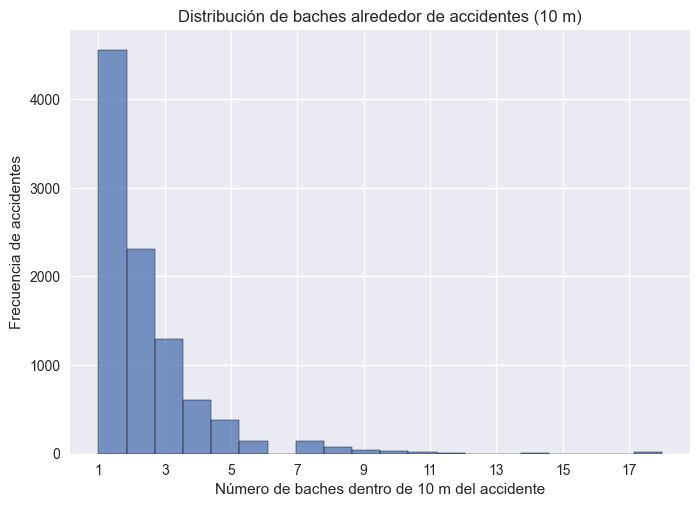

In [ ]:
sns.histplot(data=acc_baches, x='dens_baches_10m', bins=20)
plt.xlabel('Número de baches dentro de 10 m del accidente')
plt.ylabel('Frecuencia de accidentes')
# plt.yscale('log')
plt.title('Distribución de baches alrededor de accidentes (10 m)')
plt.xticks(range(1, 19, 2))
plt.show()

Podemos agrupar la cantidad de baches por accidente: 

In [107]:
acc_baches['dens_cat'] = pd.cut(
    acc_baches['dens_baches_10m'],
    bins=[0,1,3,5,20],
    labels=['1 bache','2-3 baches','4-5 baches', '6+ baches']
)

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [110]:
acc_baches['dens_cat'].value_counts(normalize=True)

dens_cat
1 bache      0.47
2-3 baches   0.38
4-5 baches   0.10
6+ baches    0.05
Name: proportion, dtype: float64

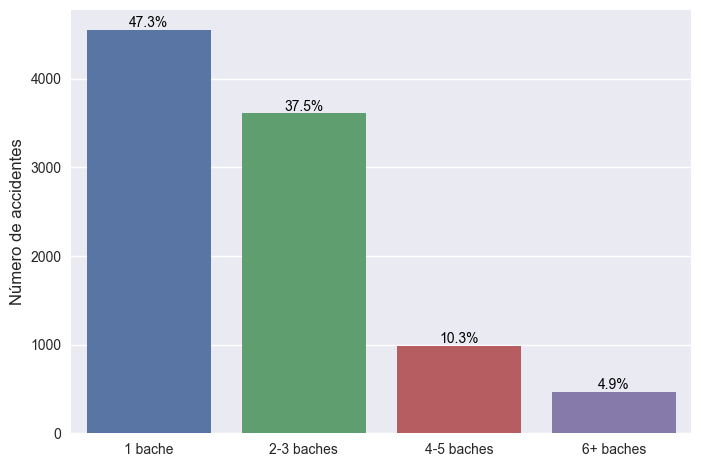

In [117]:
ax = sns.countplot(data=acc_baches, x='dens_cat', hue='dens_cat')
for p in ax.patches:
    height = p.get_height()
    pct = 100*height / len(acc_baches)  # porcentaje
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
        )
ax.set_title('', fontsize=16,pad=10)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Número de accidentes', fontsize=12)
plt.show()

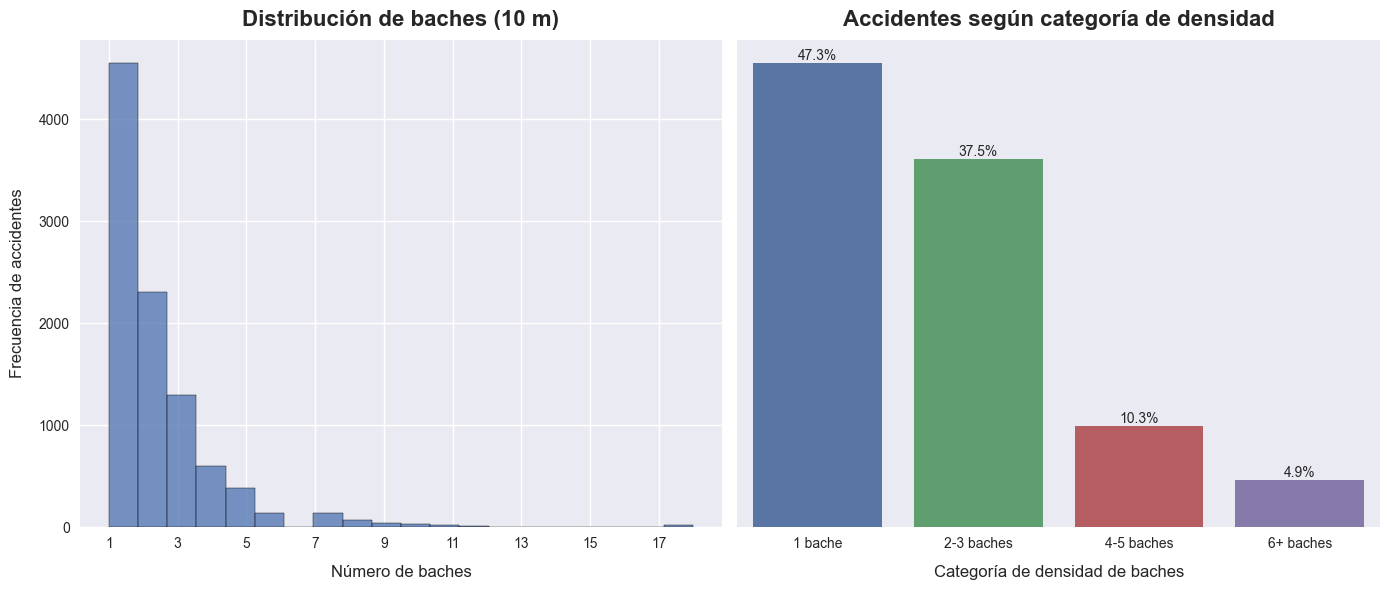

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histplot
sns.histplot(
    data=acc_baches,
    x='dens_baches_10m',
    bins=20,
    ax=axes[0]
)
axes[0].set_title('Distribución de baches (10 m)', fontsize=16, pad=10, fontweight='bold')
axes[0].set_xlabel('Número de baches', labelpad=10, fontsize=12)
axes[0].set_ylabel('Frecuencia de accidentes', labelpad=10, fontsize=12)
axes[0].set_xticks(range(1, 19, 2))

# countplot por categorías ---
ax2 = sns.countplot(
    data=acc_baches,
    x='dens_cat',
    hue='dens_cat',
    ax=axes[1]
)

for p in ax2.patches:
    height = p.get_height()
    pct = 100 * height / len(acc_baches)
    ax2.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom", fontsize=10
    )

ax2.set_title('Accidentes según categoría de densidad', fontsize=16, pad=10, fontweight='bold')
ax2.set_xlabel('Categoría de densidad de baches', labelpad=10, fontsize=12)
ax2.set_ylabel('')
ax2.set_yticks([])

plt.tight_layout()
plt.savefig("../plots/distribución-tot-baches-acc.png")
plt.show()

* El 70-75% de los accidentes ocurren en zonas con 1-3 baches activos, mostrando que los eventos se concentran en zonas donde el deterioro vial es visible. 

---

In [54]:
(
    acc_baches['tipaccid']
    .value_counts(normalize=True)
    .reset_index()
    .merge(
        gdf['tipaccid'].value_counts(normalize=True), 
        on='tipaccid'
    ).rename(columns={'proportion_x':'con_baches', 'proportion_y':'sin_baches'})
)

,tipaccid,con_baches,sin_baches
0,colisión con vehículo automotor,0.81,0.78
1,colisión con motocicleta,0.08,0.08
2,colisión con objeto fijo,0.06,0.08
3,atropellamiento,0.02,0.02
4,colisión con ciclista,0.01,0.01
5,caída de pasajero,0.01,0.01
6,volcadura,0.00,0.01
7,salida del camino,0.00,0.00


* Predominan los accidentes de tipo "colisión con vehículo automotor" con un 81%. 

* Los accidentes de tipo "colisión con vehículo automotor" aumentan un 3% al considerar la presencia de baches. 

Consideremos la clase/gravedad del accidente: 

In [56]:
(
    acc_baches['clase']
    .value_counts()
    .reset_index()
    .merge(
        gdf['clase'].value_counts(), 
        on='clase'
    ).rename(columns={'proportion_x':'con_baches', 'proportion_y':'sin_baches'})
)

,clase,count_x,count_y
0,solo daños,9122,34186
1,no fatal,483,2461
2,fatal,14,69


El total de muertos/heridos: 

In [64]:
(
    acc_baches[['totheridos', 'totmuertos']]
    .sum(axis=0)
    .reset_index(name='total')
)

,index,total
0,totheridos,571
1,totmuertos,14


In [65]:
(
    gdf[['totheridos', 'totmuertos']]
    .sum(axis=0)
    .reset_index(name='total')
)

,index,total
0,totheridos,2852
1,totmuertos,74


In [67]:
571/2852, 14/74

(0.20021037868162692, 0.1891891891891892)

---

¿Qué vialidades presentan mayor concentración de accidentes en presencia de baches?

El dataframe de los segmentos de vialidad con bache presente:

In [182]:
df_vialidad = (
    acc_baches.groupby('nombre_vialidad')
    .agg(
        n_accidentes_bache=('id', 'count'),
        densidad_media_baches=('dens_baches_10m', 'mean'),
        # tipo_vialidad=('tipo_vialidad', 'first'),
        # vel_max=('vel_max_est', 'first'),
        # num_carriles=('num_carriles_est', 'first'),
        # longitud_media=('longitud_m', 'mean')
    )
    .reset_index()
)
df_vialidad['n_accidentes'] = df_vialidad['nombre_vialidad'].map(gdf.groupby('nombre_vialidad').size())

df_vialidad['prop'] = 100*df_vialidad['n_accidentes_bache'] / df_vialidad['n_accidentes']

df_vialidad = df_vialidad[['nombre_vialidad', 'n_accidentes', 'n_accidentes_bache', 'prop', 'densidad_media_baches']]

df_vialidad.head()

,nombre_vialidad,n_accidentes,n_accidentes_bache,prop,densidad_media_baches
0,12 de octubre,180,24,13.33,1.04
1,14 de abril,68,19,27.94,1.42
2,5 de mayo,36,1,2.78,1.00
3,7 de noviembre,5,1,20.00,1.00
4,SIN_NOMBRE,2502,594,23.74,2.48


0       180
1        68
2        36
3         5
4      2502
       ... 
524      28
525     131
526      15
527      34
528      28
Name: nombre_vialidad, Length: 529, dtype: int64

Las top 10 vialidades que poseen bache cercano: 

In [187]:
(
    df_vialidad[~(df_vialidad['nombre_vialidad'] == 'SIN_NOMBRE')]
    .nlargest(10, 'n_accidentes_bache')
    .sort_values(by=['n_accidentes_bache', 'prop'], ascending=[False, False])
)

,nombre_vialidad,n_accidentes,n_accidentes_bache,prop,densidad_media_baches
193,boulevard solidaridad,3013,788,26.15,2.44
153,boulevard antonio quiroga,706,336,47.59,2.95
187,boulevard progreso,724,293,40.47,4.28
170,boulevard josé maría morelos norte,869,291,33.49,1.57
169,boulevard jesús garcía morales,669,240,35.87,2.64
183,boulevard olivares,357,207,57.98,3.11
176,boulevard luis encinas johnson,382,206,53.93,2.86
178,boulevard lázaro cárdenas,409,169,41.32,2.00
211,calle de la reforma,391,157,40.15,2.01
140,avenida xolotl,256,155,60.55,2.86


* El Boulevard Solidaridad es la vialidad con mayor cantidad de accidentes con baches
    * 3013 accidentes, de los cuales 788 (~26%) ocurrieron cerca de baches. 


* El Boulevard Olivares y Boulevard Luis Encinas Jonhson presentan proporciones más altas de accidentes con baches. 
    * Ambas vialidades superan el 50% proporción de accidentes con baches, es decir, uno de cada dos accidentes ocurre en zonas con baches presentes. 

Las densidades más altas son:
    * Boulevard Progreso: 4.28
    * Boulevard Olivares: 3.11
    * Boulevard Antonio Quiroga: 2.95

* Las principales vialdiades de la ciudad muestran una presencia significativa de accidentes en zonas con baches presentes. Esto sugiere que el deterioro de las vialidades es un factor relevante en la ocurrencia de accodentes, especialmente en tramos donde la densidad de baches es alta. 

¿En qué tipo de vialidad están más asociados los accidentes?

In [292]:
gdf.groupby('tipo_vialidad').size()

tipo_vialidad
autopista                  1
calle menor              394
calle peatonal             3
calle residencial      13528
carretera principal      660
conector autopista         5
conector carretera       129
conector primaria        346
conector secundaria       32
conector terciaria         7
vía primaria           11010
vía secundaria          4277
vía terciaria           6324
dtype: int64

In [300]:
tv = (
    acc_baches
    .groupby('tipo_vialidad')
    .agg(
        acc_con_bache = ('bache_cercano_10m','sum'),
        dens_media = ('dens_baches_10m','mean')
    )
    .reset_index()
)

tv['acc_sin_bache'] = tv['tipo_vialidad'].map(gdf.groupby('tipo_vialidad').size())

tv['prop'] = 100*tv['acc_con_bache'] / tv['acc_sin_bache']

tv = tv[['tipo_vialidad', 'acc_sin_bache','acc_con_bache','prop', 'dens_media']]

tv

,tipo_vialidad,acc_sin_bache,acc_con_bache,prop,dens_media
0,calle menor,394,60,15.23,2.03
1,calle peatonal,3,1,33.33,1.00
2,calle residencial,13528,2801,20.71,1.85
3,carretera principal,660,99,15.00,1.45
4,conector carretera,129,33,25.58,1.55
5,conector primaria,346,152,43.93,2.59
6,conector secundaria,32,15,46.88,3.87
7,vía primaria,11010,3238,29.41,2.38
8,vía secundaria,4277,1226,28.66,2.14
9,vía terciaria,6324,1994,31.53,2.42


In [302]:
df_plot = tv.sort_values('prop', ascending=False)
df_plot

,tipo_vialidad,acc_sin_bache,acc_con_bache,prop,dens_media
6,conector secundaria,32,15,46.88,3.87
5,conector primaria,346,152,43.93,2.59
1,calle peatonal,3,1,33.33,1.00
9,vía terciaria,6324,1994,31.53,2.42
7,vía primaria,11010,3238,29.41,2.38
8,vía secundaria,4277,1226,28.66,2.14
4,conector carretera,129,33,25.58,1.55
2,calle residencial,13528,2801,20.71,1.85
0,calle menor,394,60,15.23,2.03
3,carretera principal,660,99,15.00,1.45


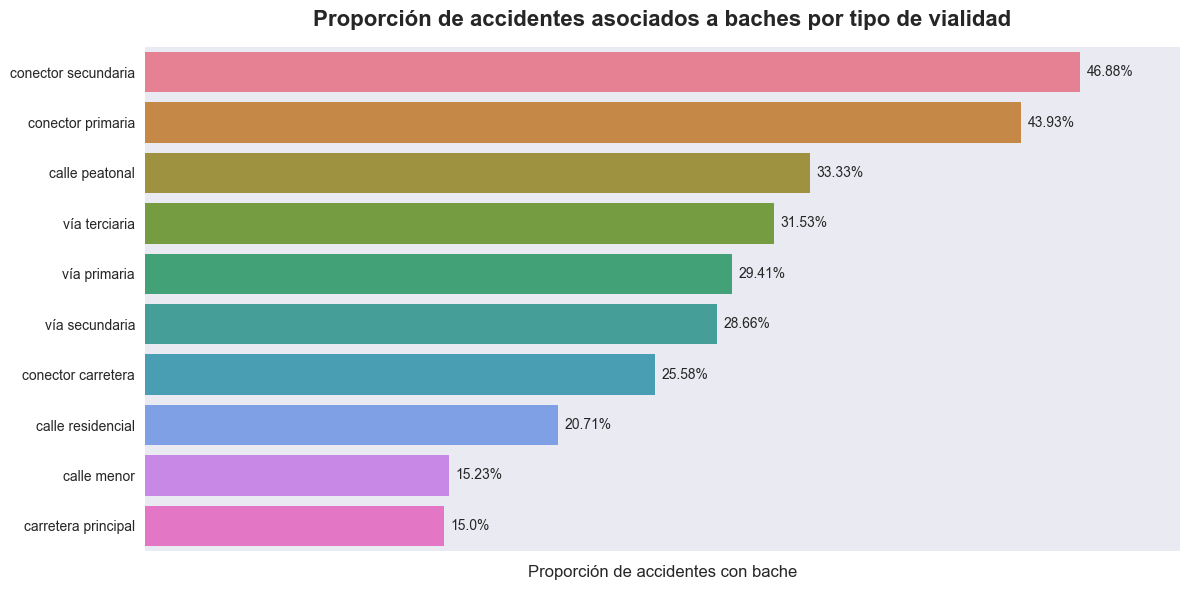

In [354]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_plot,
    x='prop',
    y='tipo_vialidad',
    hue='tipo_vialidad'
)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    pct = df_plot['prop'].reset_index(drop=True)[i]
    ax.annotate(f"{round(pct, 2)}%",
                (width + 0.325, p.get_y() + p.get_height()/2),
                va='center')

plt.xlabel('Proporción de accidentes con bache', labelpad=10, fontsize=12)
plt.ylabel('')
plt.title('Proporción de accidentes asociados a baches por tipo de vialidad', fontsize=16, fontweight='bold', pad=15)
plt.xticks([])
plt.xlim(0, df_plot['prop'].max() + 5)
plt.tight_layout()
plt.savefig("../plots/prop-acc-bache-tipo-vialidad.png")
plt.show()


* Los datos sugieren que **no son las vialdiades con más tráfico las que muestran mayor riesgo por baches**, sino las **vialdiades secundarias y de enlace**, posiblemente por menor frecuencia de reparaciones y menor supervición. 

* **Los accidentes relacionados con baches se concentran proporcionalmente en vialidades de menor jerarquía (conectores y vías terciarias). Estas deberían de ser priorizadas en programas de mantenimiento, pues combinan alta presencia de baches con un riesgo más elevado de accidentes**. 

Scatterplot de la proporción de accidentes con baches y la densidad media de baches: 

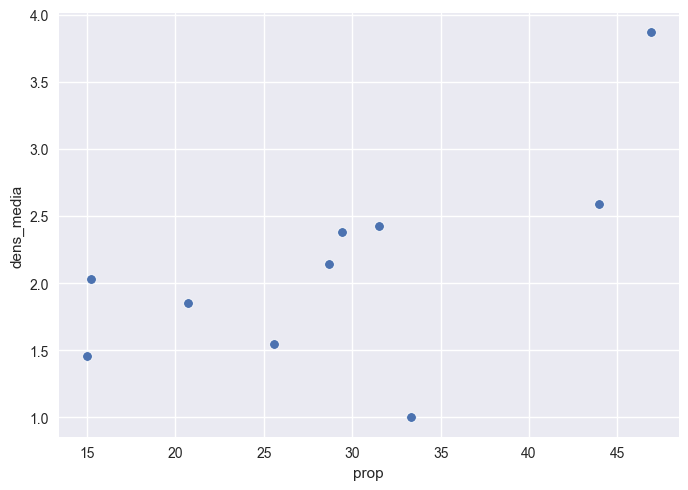

In [348]:
sns.scatterplot(data=df_plot, x='prop', y='dens_media')
plt.show()

---

¿Los accidentes cerca de baches tienden a ser más graves?

In [189]:
acc_baches.columns

Index(['id', 'fecha_acc', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
       'urbana', 'suburbana', 'tipaccid', 'causaacci', 'caparod', 'clase',
       'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
       'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
       'bicicleta', 'otrovehic', 'sexo', 'edad', 'aliento', 'cinturon',
       'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto',
       'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido',
       'totmuertos', 'totheridos', 'geometry_atus', 'index_right',
       'tipo_vialidad', 'nombre_vialidad', 'un_sentido', 'longitud_m',
       'vel_max', 'num_carriles', 'vel_max_est', 'num_carriles_est',
       'distance_m', 'geometry_vialidad', 'dist_bache_min_m',
       'bache_cercano_10m', 'baches_geom_10m', 'dens_baches_10m',
       'bache_cercano_15m', 'baches_geom_15m', 'dens_baches_15m',
       'bache_cercano_20m', 'baches_geom_20m', 'dens_baches_20m',
    

In [203]:
clase_acc_bache = (
    acc_baches['clase']
    .value_counts()
    .reset_index(name='total_acc')
    .merge(
        gdf['clase']
        .value_counts()
        .reset_index(name='total_acc'), 
        on='clase'
    )
    .rename(columns={'total_acc_x': 'bache_cercano', 'total_acc_y': 'total_acc'})
)
clase_acc_bache['prop'] = clase_acc_bache['bache_cercano'] / clase_acc_bache['total_acc']

clase_acc_bache = clase_acc_bache[['clase', 'total_acc', 'bache_cercano', 'prop']]

clase_acc_bache

,clase,total_acc,bache_cercano,prop
0,solo daños,34186,9122,0.27
1,no fatal,2461,483,0.20
2,fatal,69,14,0.20


In [220]:
df_prop = clase_acc_bache.assign(prop = clase_acc_bache['bache_cercano'] / clase_acc_bache['total_acc'])

In [226]:
clase_acc_bache['prop'][0]

np.float64(0.2668343766454104)

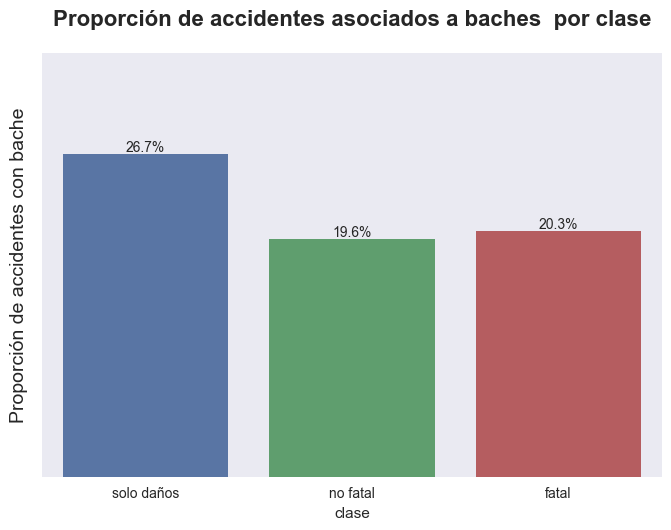

In [345]:
ax = sns.barplot(data=clase_acc_bache, x='clase', y='prop', hue='clase')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    pct = 100*clase_acc_bache['prop'][i]
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom", fontsize=10
)
plt.title('Proporción de accidentes asociados a baches  por clase', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Proporción de accidentes con bache', fontsize=14, labelpad=10)
plt.ylim(0, 0.35)
plt.yticks([])
plt.savefig("../plots/proporcion-acc-clase.png")
plt.show()

* Los accidentes con *solo daños* muestran una porporción ligeramente mayor de ocurrencias cerca de un bache (~30%) en comparación con los accidentes *no fatales* y *fatales*, que precentan proporciones similares (20%). Esto sugiere que, aunque los baches están asociados a accidentes en general, **no parecen incrementar la gravedad** del accidente; más bien , su presencia se distribuye de forma parecida entre eventos *no fatales* y *fatales*.

In [217]:
df_long = pd.melt(clase_acc_bache, id_vars='clase', value_vars=['total_acc', 'bache_cercano'], 
                  var_name='tipo_accidente', value_name='valor')

df_long


,clase,tipo_accidente,valor
0,solo daños,total_acc,34186
1,no fatal,total_acc,2461
2,fatal,total_acc,69
3,solo daños,bache_cercano,9122
4,no fatal,bache_cercano,483
5,fatal,bache_cercano,14


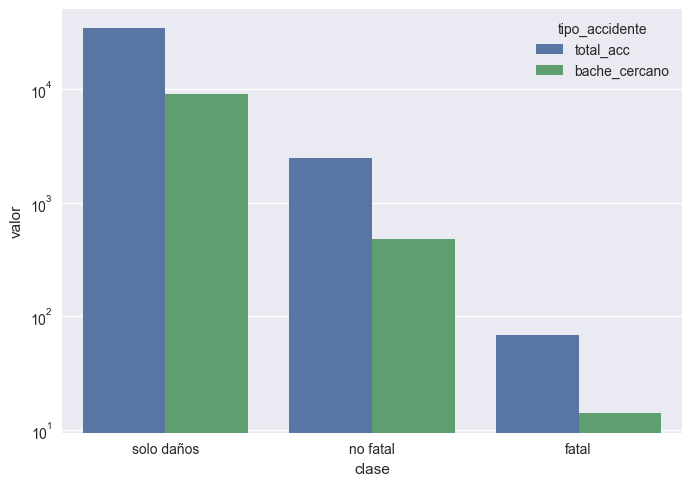

In [219]:
sns.barplot(data=df_long, x='clase', y='valor', hue='tipo_accidente')
plt.yscale('log')
plt.show()

---


¿Los accidentes ocurren más frecuentemente cuando hubo un bache reportado días antes que no fue antendido?

¿Existe relación entre la ocurrencia de los accidentes y el tiempo en el que el bache fue reportado?

La columna `bache_previo_dias` posee información siguiente: 

    Para un accindente, se obtienen los baches activos en un radio de 10 metros, de estos se obtiene la fecha más cercana al accidente y se calcula la diferencia entre la fecha del accidente y la fehca de reporte. 

In [230]:
acc_baches['bache_previo_dias'].describe()

count   9615.00
mean     237.95
std      184.40
min        0.00
25%       87.00
50%      198.00
75%      354.50
max      817.00
Name: bache_previo_dias, dtype: float64

* En promedio, transcurren 237 días desde el reporte hasta la ocurrencia de un accidente con 180 días de desviación estandar. 

* En el 25% de los accidentes con baches activos transcurren 90 días desde el reporte de un bache y la ocurrencia del accidente.  

* El máximo de días transcurridos es de 817: hay baches viejos que nunca se reparan, y accidentes que ocurren cerca de ellos simplemente porque llevan demasiado tiempo ahí. 

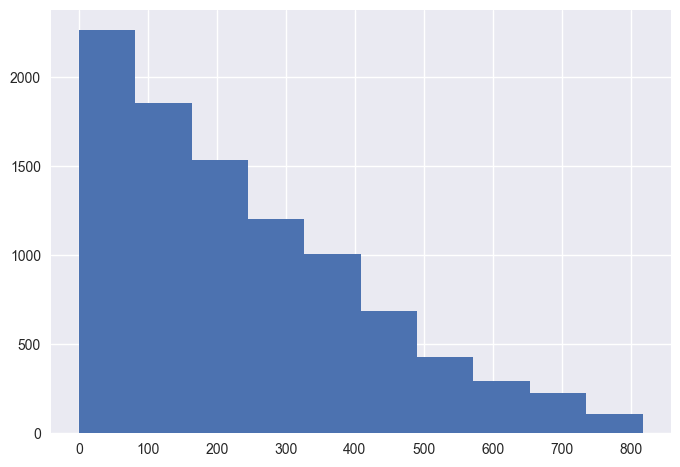

In [232]:
acc_baches['bache_previo_dias'].hist()
plt.show()

Consideremos periodos de tiempo par la columna `bache_previo_dias`: 

1. **0–30 días**: bache recién reportado

2. **31–90 días**: bache reciente pero no atendido

3. **91–180 días**: bache con antigüedad moderada

4. **181–365 días**: bache muy viejo

5. **365+ días**: baches abandonados

In [ ]:
bins = [0, 30, 90, 180, 365, acc_baches['bache_previo_dias'].max()]
labels = [
    '0-30 días',
    '31-90 días',
    '91-180 días',
    '181-365 días',
    '365+ días'
]

In [234]:
acc_baches['edad_bache_cat'] = pd.cut(
    acc_baches['bache_previo_dias'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [235]:
acc_baches['edad_bache_cat'].value_counts().sort_index()

edad_bache_cat
0-30 días        934
31-90 días      1568
91-180 días     1947
181-365 días    2898
365+ días       2268
Name: count, dtype: int64

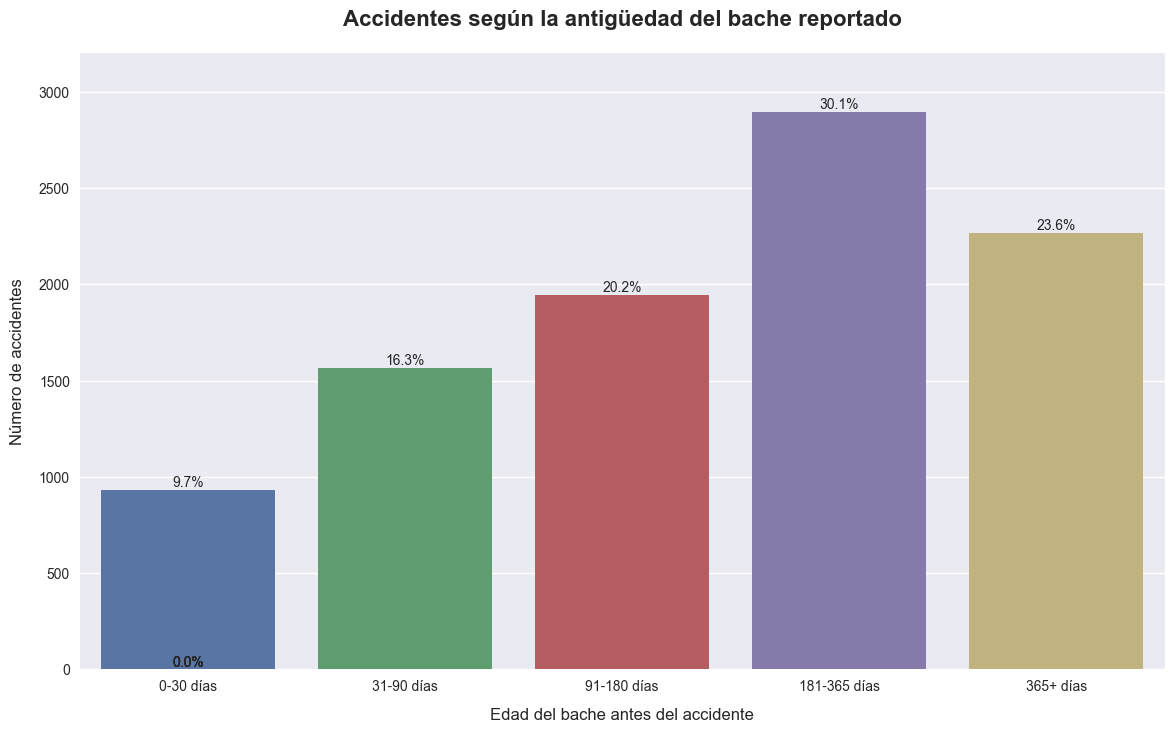

In [267]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=acc_baches, x='edad_bache_cat', hue='edad_bache_cat')

for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / len(acc_baches)
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom", fontsize=10
    )

plt.ylim(0, 3200)
plt.xlabel('Edad del bache antes del accidente', labelpad=10, fontsize=12)
plt.ylabel('Número de accidentes', fontsize=12, labelpad=10)
plt.legend().remove()
plt.title('Accidentes según la antigüedad del bache reportado', fontsize=16, pad=20, fontweight='bold')
plt.savefig("../plots/acc_bache_viejo.png")
plt.show()

* **Los accidentes son menos frecuentes alrededor de baches recién reportados (0-30 días) y aumentan progresivamente conforme pasa el tiempo.**

* Solo el **9.7%** de los accidentes se vinculan a baches on menos de 30 días de antigüedad. En contraste, más del **53%** de los accidentes ocurren alrededor de baches con más de 180 días sin reparación.
    + Esto sugiere que **la permanencia prolongada de un bache incrementa su contribucuón al riesgo de accidentes**, por lo que la atención temprana podría tener impacto preventivo significativo. 

---

In [274]:
cols = ['vel_max', 'vel_max_est', 'num_carriles', 'num_carriles_est', 'tipo_vialidad']
acc_baches[cols].notna().mean().round(3)

vel_max            0.21
vel_max_est        1.00
num_carriles       0.25
num_carriles_est   1.00
tipo_vialidad      1.00
dtype: float64

In [ ]:
acc_baches['vel_max'].value_counts()

vel_max
60        1256
50         281
30         228
70         133
45          85
40          37
90          25
60;110      16
20           8
Name: count, dtype: int64

In [276]:
acc_baches['num_carriles'].value_counts()

num_carriles
4      869
3      531
2      485
5      401
1       89
2;3      1
Name: count, dtype: int64

## x. Conclusiones